# Evasion Attacks in ART

This notebook will demonstrate how to use ART to perform evasion attacks on an image classifier. This demo will specifically use the PyTorch classifier on the MNIST dataset. We will demonstrate the Projected Gradient Descent (white-box attack) and Square Attack (black-box attack).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import SquareAttack
from art.utils import load_dataset

## The Attack: Misclassify an Image

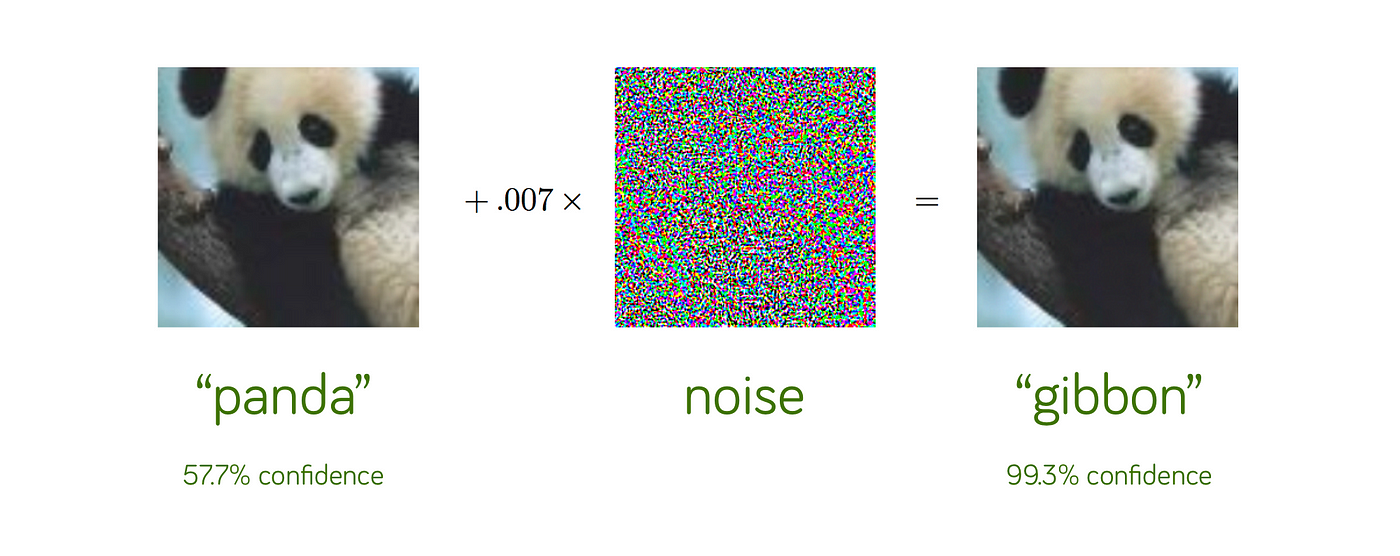

## Load Dataset

We will first use ART to load the MNIST dataset. Since we are using PyTorch, we need to cast to `np.float32` and move the channels dimension (`NCHW`). We also convert the one-hot encoded labels into class indices

In [2]:
(x_train, y_train), (x_test, y_test), _, _ = load_dataset('mnist')

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

print(f'x_train:', x_train.dtype, x_train.shape)
print(f'y_train:', y_train.dtype, y_train.shape)
print(f'x_test: ', x_test.dtype, x_test.shape)
print(f'y_test: ', y_test.dtype, y_test.shape)

x_train: float32 (60000, 1, 28, 28)
y_train: int64 (60000,)
x_test:  float32 (10000, 1, 28, 28)
y_test:  int64 (10000,)


We use a smaller sample of the training data for this demo for quick training.

In [3]:
n_train = np.shape(x_train)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_train = x_train[random_selection_indices]
y_train = y_train[random_selection_indices]

print(f'x_train:', x_train.dtype, x_train.shape)
print(f'y_train:', y_train.dtype, y_train.shape)

x_train: float32 (7500, 1, 28, 28)
y_train: int64 (7500,)


## Create and Train Classifier

First, we will create a simple Convolutional Neural Network (CNN) using PyTorch for classifying the MNIST dataset.

In [4]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=256, out_features=84),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=84, out_features=10),
)

model

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=84, bias=True)
  (8): ReLU()
  (9): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

classifier = PyTorchClassifier(
    model=model,
    loss=loss,
    input_shape=(1, 28, 28),
    nb_classes=10,
    optimizer=optimizer,
    clip_values=(0, 1),
)

In [6]:
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [7]:
y_pred_train= classifier.predict(x_train).argmax(axis=1)
y_pred_test = classifier.predict(x_test).argmax(axis=1)

acc_train = np.mean(y_pred_train == y_train)
acc_test = np.mean(y_pred_test == y_test)

print(f'train accuracy: {(acc_train * 100):.2f}%')
print(f'test accuracy: {(acc_test * 100):.2f}%')

train accuracy: 93.60%
test accuracy: 93.94%


## Projected Gradient Descent Attack

We demonstrate how to use Projected Gradient Descent (PGD) which is white-box attack.

In [8]:
attack = ProjectedGradientDescent(classifier, norm=np.inf, eps=0.3, eps_step=0.1, max_iter=3)
x_adv = attack.generate(x_test, y_test)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

We now check how the accuracy of the model is affected by these adversarial images.

In [9]:
y_pred_test = classifier.predict(x_test).argmax(axis=1)
y_pred_adv = classifier.predict(x_adv).argmax(axis=1)

acc_test = np.mean(y_pred_test == y_test)
acc_adv = np.mean(y_pred_adv == y_test)

print(f'clean accuracy: {(acc_test * 100):.2f}%')
print(f'adversarial accuracy: {(acc_adv * 100):.2f}%')

clean accuracy: 93.94%
adversarial accuracy: 0.53%


Lastly, we show what the adversarial images look like.

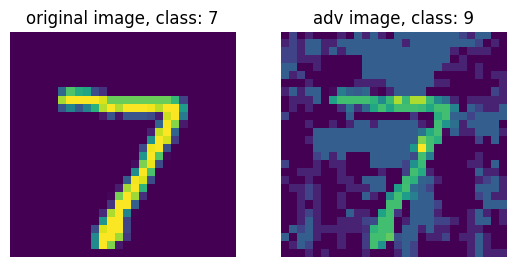

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(x_test[0].squeeze())
ax1.set_title(f'original image, class: {y_pred_test[0]}')
ax1.axis('off')

ax2.imshow(x_adv[0].squeeze())
ax2.set_title(f'adv image, class: {y_pred_adv[0]}')
ax2.axis('off')

plt.show()

## Square Attack

We demonstrate how to use Square Attack which is a black-box attack.

In [12]:
attack = SquareAttack(classifier, norm=np.inf, eps=0.3, max_iter=10)
x_adv = attack.generate(x_test, y_test)

SquareAttack - restarts:   0%|          | 0/1 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/10 [00:00<?, ?it/s]

We now check how the accuracy of the model is affected by these adversarial images.

In [13]:
y_pred_test = classifier.predict(x_test).argmax(axis=1)
y_pred_adv = classifier.predict(x_adv).argmax(axis=1)

acc_test = np.mean(y_pred_test == y_test)
acc_adv = np.mean(y_pred_adv == y_test)

print(f'clean accuracy: {(acc_test * 100):.2f}%')
print(f'adversarial accuracy: {(acc_adv * 100):.2f}%')

clean accuracy: 93.94%
adversarial accuracy: 65.79%


Lastly, we show what the adversarial images look like.

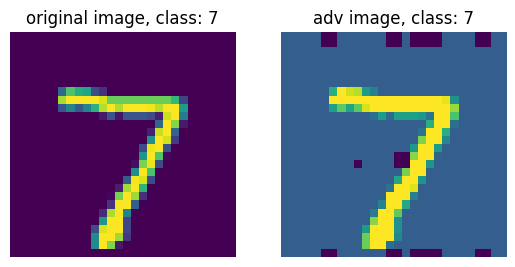

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(x_test[0].squeeze())
ax1.set_title(f'original image, class: {y_pred_test[0]}')
ax1.axis('off')

ax2.imshow(x_adv[0].squeeze())
ax2.set_title(f'adv image, class: {y_pred_adv[0]}')
ax2.axis('off')

plt.show()